# Custom Packet Test - First Calibration

In [1]:
import math, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lf

#Select a file.
data = pd.read_csv("data/scale5_det22-23_delay5_base0_Na_t-man1060.txt",header=0)

## Initial Plotting
Before choosing calibration lines, let's look at data from both detectors. (Detectors besides 22 and 23 were disabled for this run.)

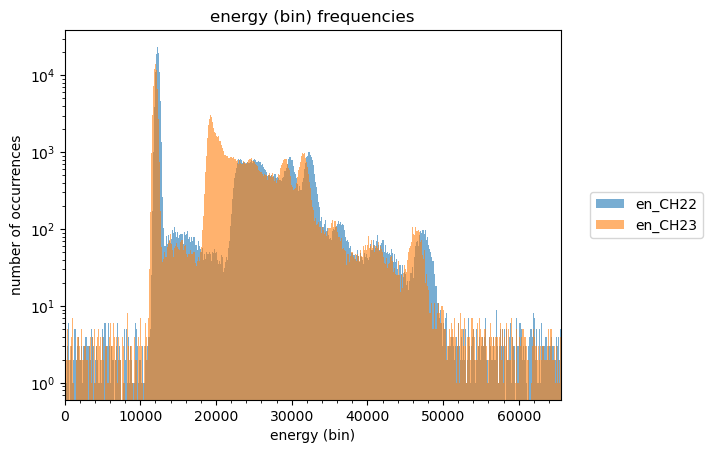

In [2]:
bins_all = np.arange(0,2**16,16) #The full range of possible values the packet can save.
for i in range(22,24):           #This limits plotting to the relevant channels.
    label = 'en_CH'+str(i)
    chdat = [int(x,16) for x in data[label].values] #Convert data from hex stringt to integer
    plt.hist(chdat,alpha=0.6,label=label,bins=bins_all) #alpha makes both visible, not just whatever's in front.

#Labeling
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))
plt.title("energy (bin) frequencies")
plt.xlabel("energy (bin)")
plt.ylabel("number of occurrences")
plt.yscale('log')
plt.minorticks_on()

plt.xlim(0,2**16)
plt.show()

There's a weird discrepancy around 20k, but I'm not sure why. It doesn't look like it's directly to do with the calibration, because it's a larger discrepancy than elsewhere. Other possibilities:
* There is a source creating data in this region that is blocked from det22's line of sight, but not det23.
* These are related to the odd sinusoidal signals that we see in det23 on occassion. (See [OneNote:Neutron Capture>R76Firmware + SCI-Compiler/DAQ Working Summary/CAEN-Only Data](https://olucdenver-my.sharepoint.com/personal/kathryn_mikelson_ucdenver_edu/_layouts/OneNote.aspx?id=%2Fpersonal%2Fkathryn_mikelson_ucdenver_edu%2FDocuments%2FNeutron%20Capture&wd=target%28R76Firmware%20%2B%20SCI-Compiler.one%7CB03E499E-9E4D-4016-A1A7-902F75D66489%2FCAEN-Only%20Data%7C546D553C-1068-4F19-A41E-B7D1B2D6AF02%2F%29).)

We don't have an immediate solution for that, so let's move on to calibrating detector 22.

## Finding calibration lines

It's not clear from the initial plot where the calibration lines live. Let's plot just the detector 22 data with vertical grid lines.

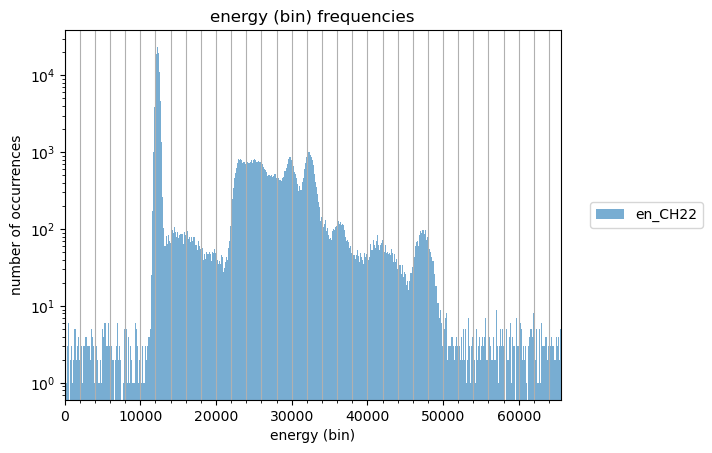

In [3]:
#One detector with vertical lines for 
for i in range(22,23):
    label = 'en_CH'+str(i)
    chdat = [int(x,16) for x in data[label].values]
    plt.hist(chdat,alpha=0.6,label=label,bins=bins_all) #darker because these are the ones that can trigger
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))
plt.title("energy (bin) frequencies")
plt.xlabel("energy (bin)")
plt.ylabel("number of occurrences")
plt.yscale('log')
plt.grid(visible=True,which="both",axis="x")
plt.minorticks_on()
plt.xlim(0,2**16)
plt.show()

Now, we can use these grid lines to make some initial guesses as to where the emission lines are, based on where we see peaks.

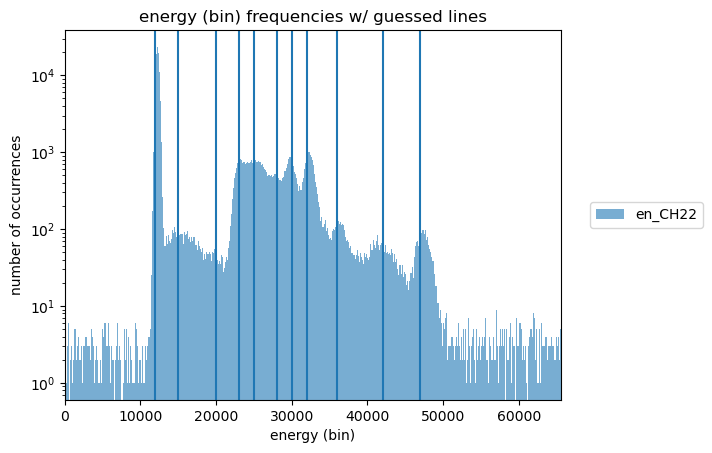

In [4]:
binpoints = [12000,15000,20000,23000,25000,28000,30000,32000,36000,42000,47000]
for i in range(22,23):
    label = 'en_CH'+str(i)
    chdat = [int(x,16) for x in data[label].values]
    plt.hist(chdat,alpha=0.6,label=label,bins=bins_all) #darker because these are the ones that can trigger
for x in binpoints:
    plt.axvline(x)
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))
plt.title("energy (bin) frequencies w/ guessed lines")
plt.xlabel("energy (bin)")
plt.ylabel("number of occurrences")
plt.yscale('log')
plt.xlim(0,2**16)
plt.show()

Some of these look like they may be combinations of other lines, or otherwise not be meaningful -- specifically: 
* The third line is small and appears to be the sum of the first two, which could make it the sum of $^{22}$Na's emission lines.
* If the first line is the "0" point, then it makes sense based on scale to treat 15k and 32k as the 411 and 1275keV lines respectively, so we remove their sum.
* While the 47k line appears to be a sum of other values, there isn't a clear physical meaning in combining the 15k line with the 32k line, so we keep the 47k line.

Let's do a quick adjustment that shows the possible combination lines:

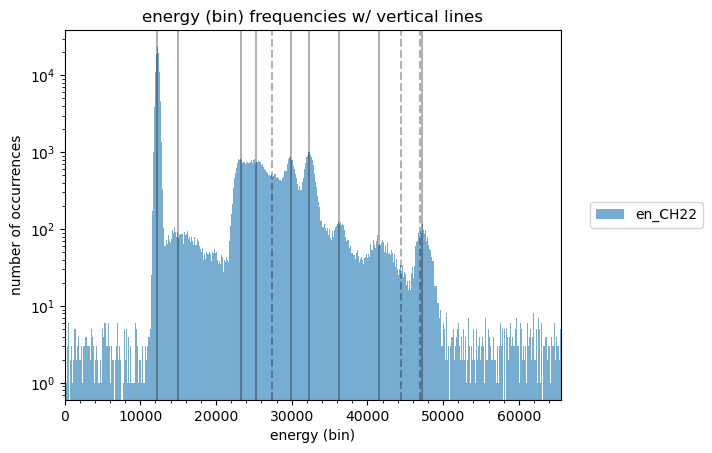

In [5]:
binpoints = [12200,15000,23300,25300,29900,32300,36200,41500,47200]
#extendedpoints = [x+y for x,y in itertools.combinations(binpoints,r=2)]
extendedpoints = [x+y for x,y in itertools.combinations([12400,15000,32000],r=2)]
for i in range(22,23):
    label = 'en_CH'+str(i)
    chdat = [int(x,16) for x in data[label].values]
    hist = plt.hist(chdat,alpha=0.6,label=label,bins=bins_all) #darker because these are the ones that can trigger
for x in binpoints:
    plt.axvline(x,alpha=0.3,color='k')
for x in extendedpoints:
    plt.axvline(x,alpha=0.3,linestyle='--',color='k')
    pass #for when I comment out the above line
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))
plt.title("energy (bin) frequencies w/ vertical lines")
plt.xlabel("energy (bin)")
plt.ylabel("number of occurrences")
#plt.ylim(0,1250)
plt.xlim(0,max(chdat))
plt.yscale('log')
plt.minorticks_on()
plt.show()

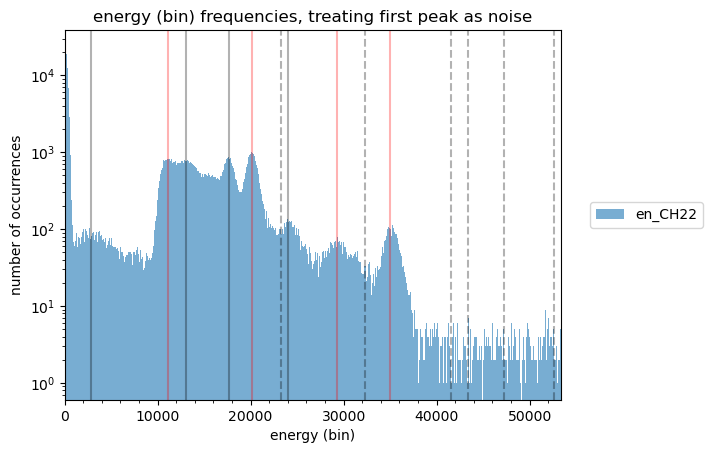

In [6]:
#Energies we should be aligning to.
energypoints = [0,511,1275] #22Na
energypoints.append(2168) #Potassium-38. also emits 511 but that's already included.
energypoints.append(2615) #Thallium-208
energypoints.sort()
redbinpoints = [12200,23300,32300,41500,47200] #Points I think correspond to something
extendedpoints = [x+y for x,y in itertools.combinations(redbinpoints,r=2)]
for i in range(22,23):
    label = 'en_CH'+str(i)
    chdat = [int(x,16)-binpoints[0] for x in data[label].values]
    plt.hist(chdat,alpha=0.6,label=label,bins=bins_all) #darker because these are the ones that can trigger
for x in binpoints:
    if x in redbinpoints:
        plt.axvline(x-binpoints[0],alpha=0.3,color='r')
    else:
        plt.axvline(x-binpoints[0],alpha=0.3,color='k')
for x in extendedpoints:
    plt.axvline(x-binpoints[0],alpha=0.3,linestyle='--',color='k')
    pass #for when I comment out the above line
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))
plt.title("energy (bin) frequencies, treating first peak as noise")
plt.xlabel("energy (bin)")
plt.ylabel("number of occurrences")
#plt.ylim(0,1250)
plt.xlim(0,max(chdat))
plt.yscale('log')
plt.minorticks_on()
plt.show()

And, just to double-check that these peaks seem sensible, I'll remove all scaling -- both the log scale from matplotlib and the scaling factor that I provided during data collection.

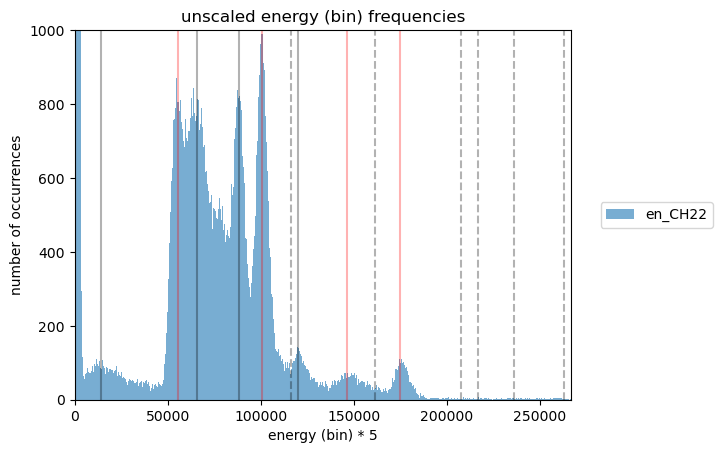

In [7]:
scalefactor = 5

bins_scaled = bins_all*scalefactor;
for i in range(22,23):
    label = 'en_CH'+str(i)
    chdat = [scalefactor*(int(x,16)-binpoints[0]) for x in data[label].values]
    plt.hist(chdat,alpha=0.6,label=label,bins=bins_scaled) #darker because these are the ones that can trigger
for x in binpoints:
    if x in redbinpoints:
        plt.axvline((x-binpoints[0])*scalefactor,alpha=0.3,color='r')
    else:
        plt.axvline((x-binpoints[0])*scalefactor,alpha=0.3,color='k')
for x in extendedpoints:
    plt.axvline((x-binpoints[0])*scalefactor,alpha=0.3,linestyle='--',color='k')
    pass #for when I comment out the above line
plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))
plt.title("unscaled energy (bin) frequencies")
plt.xlabel("energy (bin) * "+str(scalefactor))
plt.ylabel("number of occurrences")
plt.xlim(0,scalefactor*(2**16-binpoints[0]))
plt.ylim(0,1000)
plt.show()

## Calibration

For now, we'll calibrate based on these values selected by eye.

[0.03471050672503116, 0.032461373658059775, 0.1125087900926024, 0.09712858623572641]


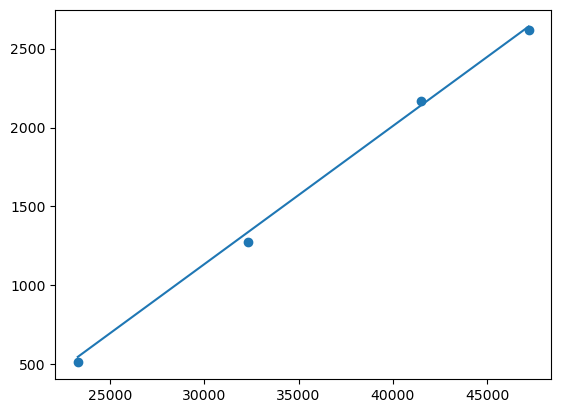

In [8]:
redbinpoints = redbinpoints[1:] #don't force 0, I think that was a mistake and I've selected the wrong 0 point
energypoints = energypoints[1:] #actually not forcing it somehow makes the fit worse
def line(x,m=1,b=0): #we're getting into the REAL complicated stats now watch out
    return m*x+b
#print(redbinpoints,energypoints)
plt.scatter(redbinpoints,energypoints)
weights = [1/np.sqrt(hist[0][max(np.where(hist[1] <= x)[0])]) for x in redbinpoints]
print(weights)

l_model = lf.Model(line)
l_params = l_model.make_params(m=0,b=0)
l_fit = l_model.fit(energypoints,l_params,x=redbinpoints,weights=weights)
l_dict = l_fit.best_values

plt.plot(redbinpoints,[line(x,m=l_dict['m'],b=l_dict['b']) for x in redbinpoints])
plt.show()
l_fit

## Improvements to be made
* I need to figure out what all these other apparent lines are.
* Solve whatever's causing the discrepancy between the two detectors
* Data with shielding up may be helpful
* Change hand-selection to initial value for maximum finding
    * Change found maxima to gaussian peak detection (some of these have pretty hefty overlap.)
        * Change heights used for weighting to match heights obtained from maxima.